In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


## Model definition

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [2]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 12e3, -2e3, 2e3, 0, 4e3], resolution=[500,1,500])

Active grids: ['regular']


2-layers  2020-03-09 20:18

In [3]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')
dz = geo_model.grid.regular_grid.dz
geo_model.surfaces.add_surfaces_values([dz, 0, 0], ['dz'])
geo_model.surfaces.add_surfaces_values(np.array([2.6, 2.4, 3.2]), ['density'])

,surface,series,order_surfaces,isActive,color,id,dz,density
0,surface 1,Default series,1,nan,#015482,1,8,2.6
1,surface 2,Default series,2,nan,#9f0052,2,0,2.4
2,basement,Default series,3,nan,#ffbe00,3,0,3.2


In [4]:
geo_model.add_surface_points(3e3, 0, 3.05e3, 'surface 1')
geo_model.add_surface_points(9e3, 0, 3.05e3, 'surface 1')

geo_model.add_surface_points(3e3, 0, 1.02e3, 'surface 2')
geo_model.add_surface_points(9e3, 0, 1.02e3, 'surface 2')

geo_model.add_orientations(  6e3, 0, 4e3, 'surface 1', [0,0,1])

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,6000.0,0.0,4000.0,0.5001,0.5001,0.624267,0.0,0.0,1.0,0.0,0.0,1.0,surface 1,Default series,1,1,0.01


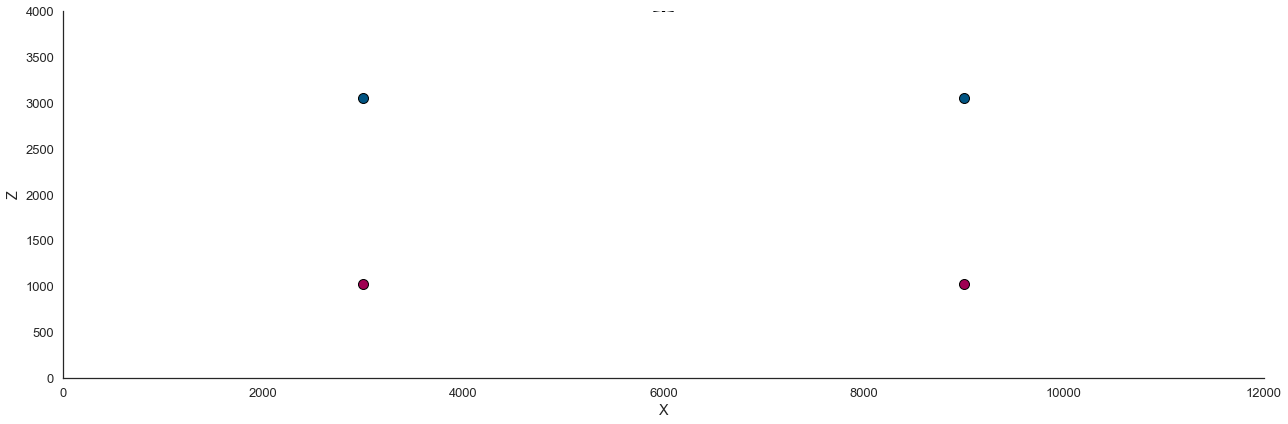

In [5]:
gp.plot.plot_data(geo_model)

### Plots:

In [6]:
import arviz as az


#### Load data

In [7]:
# data = az.from_netcdf('gravity_easy')
# data = az.from_netcdf('gravity_thin_layer_2')
data = az.from_netcdf('australia')

In [8]:
data.prior['depth_0'] = data.prior['depths'][0 ,:, 0]
data.prior['depth_1'] = data.prior['depths'][0 ,:, 1]
data.prior['depth_2'] = data.prior['depths'][0 ,:, 2]
data.prior['depth_3'] = data.prior['depths'][0 ,:, 3]

In [9]:
data.posterior['depth_0'] =  data.posterior['depths'][0 ,:, 0]
data.posterior['depth_1'] =  data.posterior['depths'][0 ,:, 1]
data.posterior['depth_2'] =  data.posterior['depths'][0 ,:, 2]
data.posterior['depth_3'] =  data.posterior['depths'][0 ,:, 3]

In [10]:
data.posterior['like_std2'] = np.array([5]*200)

In [11]:
data.posterior

<xarray.Dataset>
Dimensions:           (chain: 1, depths_dim_0: 4, draw: 700, like_std2: 200)
Coordinates:
  * chain             (chain) int64 0
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 693 694 695 696 697 698 699
  * depths_dim_0      (depths_dim_0) int64 0 1 2 3
  * like_std2         (like_std2) int64 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5
Data variables:
    depths            (chain, draw, depths_dim_0) float32 ...
    sigma             (chain, draw) float32 ...
    gravity           (chain, draw) float32 ...
    thick_1           (chain, draw) float32 ...
    thick_2           (chain, draw) float32 ...
    sigma_thickness   (chain, draw) float32 ...
    sigma2_thickness  (chain, draw) float32 ...
    depth_0           (draw) float32 ...
    depth_1           (draw) float32 ...
    depth_2           (draw) float32 ...
    depth_3           (draw) float32 ...
Attributes:
    created_at:                 2020-03-06T14:06:45.859431
    inference_library:          pymc3
    

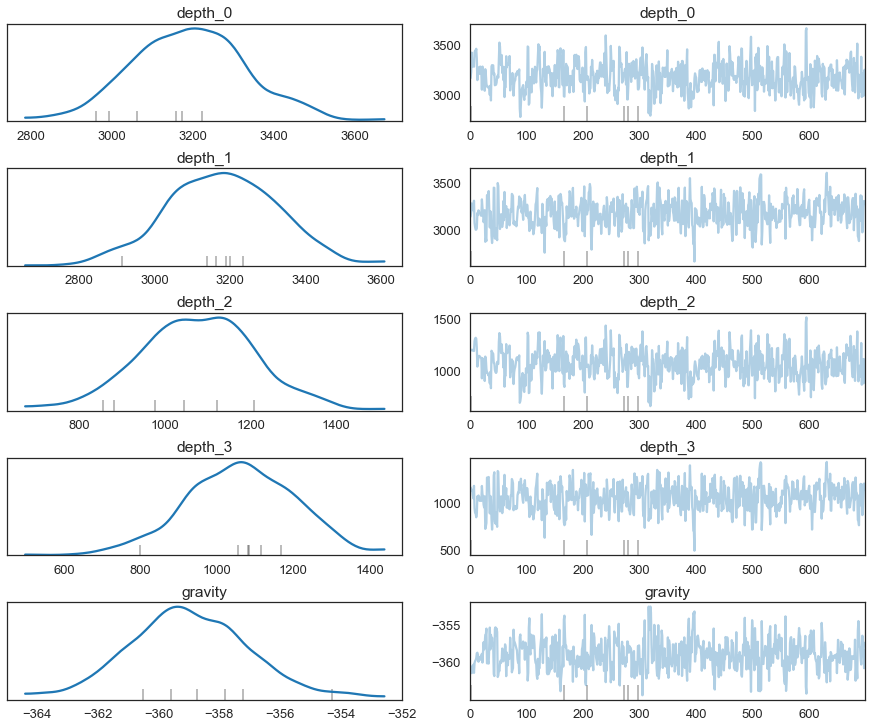

In [19]:
az.plot_trace(data, var_names=['depth_0', 'depth_1', 'depth_2', 'depth_3', 'gravity']);


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb101eead30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb112d66f28>)

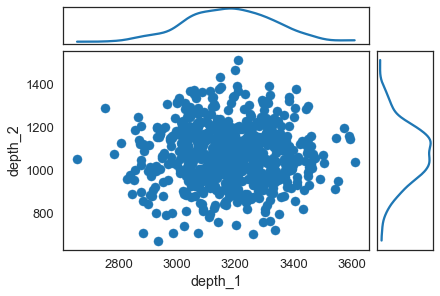

In [20]:
az.plot_joint(data, var_names=['depth_1', 'depth_2'])

In [15]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


In [22]:
def change_iteration(iteration):
    p.plot_posterior(['depth_1', 'depth_3'], ['gravity', 'sigma'], 'y', iteration)
    #p.axjoin.set_xlim(2000, 14000)
    #p.axjoin.set_ylim(2000, 14000)
  #  geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
  #  gp.compute_model(geo_model, output='gravity')
  #  gp.plot.plot_section(geo_model, 0)
    
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

<IPython.core.display.Javascript object>


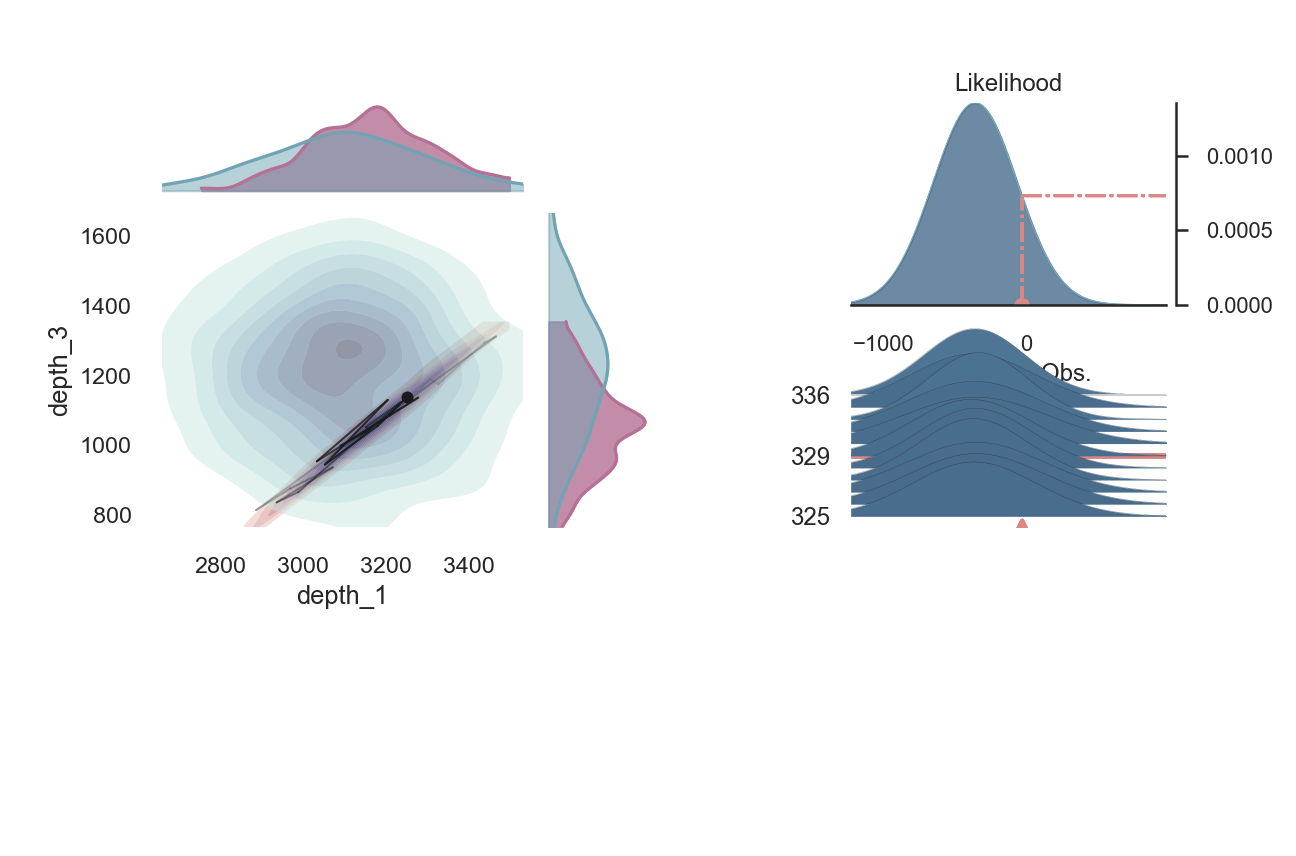

In [24]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [25]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 700, 30))

interactive(children=(IntSlider(value=330, description='iteration', max=700, step=30), Output()), _dom_classes…

<function __main__.change_iteration(iteration)>

<IPython.core.display.Javascript object>


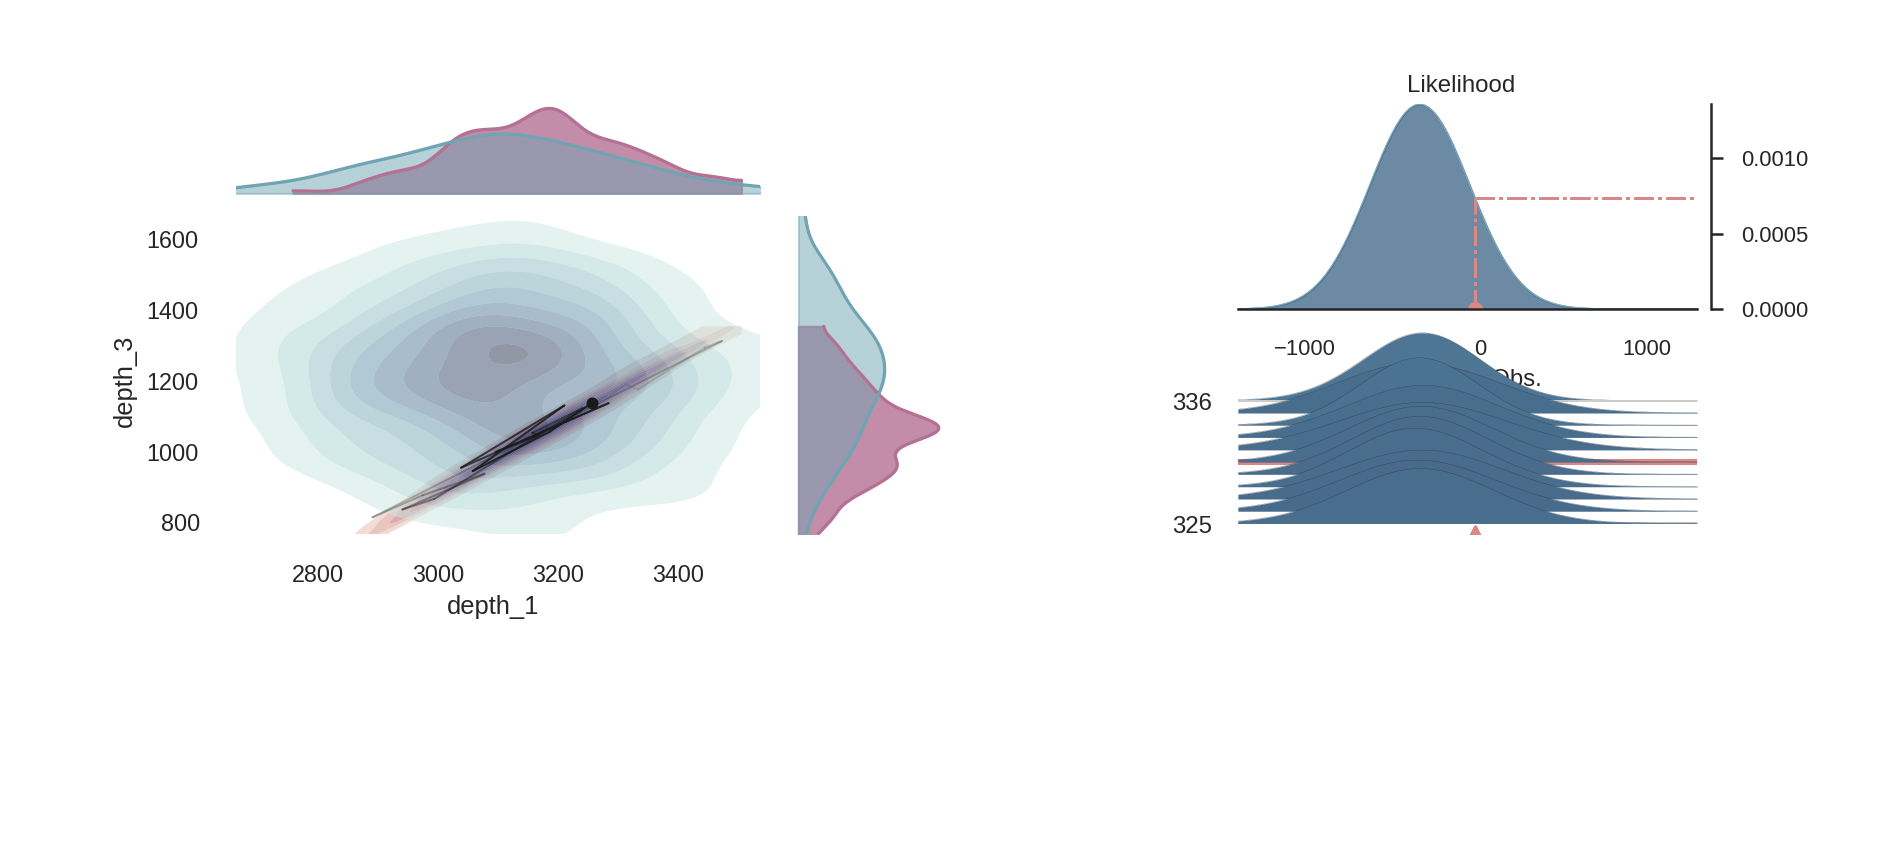

In [71]:
p.fig.add_axes()

-----
## Gif 2D


In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


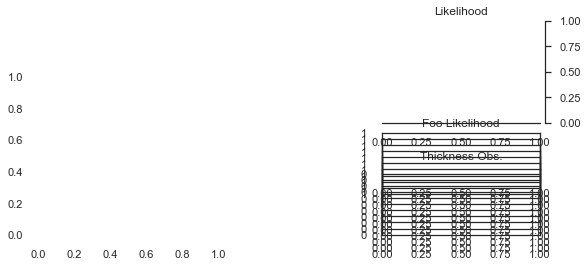

In [13]:
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,6), joyplot=True)


In [20]:
image_list2 = []
for i in range(0, 700, 1):
    p.plot_posterior(['depth_1', 'depth_3'], ['gravity', 'sigma'], 'y', i)
    # Used to return the plot as an image rray
    fig = p.fig     # draw the canvas, cache the renderer
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_list2.append(image)

In [22]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./hard1_slow_mo.mov', image_list2, fps=3)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 432) to (656, 432) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [23]:
imageio.mimsave('./hard1.mov', image_list2, fps=9)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 432) to (656, 432) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [47]:
fig.canvas.get_width_height()[::-1] + (3,), 432*648*3

((432, 648, 3), 839808)

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

## Plot 3D

In [24]:
geo_model.set_regular_grid(geo_model.grid.regular_grid.extent, [40,20,40])

Active grids: ['regular']


Grid Object. Values: 
array([[  150., -1900.,    50.],
       [  150., -1900.,   150.],
       [  150., -1900.,   250.],
       ...,
       [11850.,  1900.,  3750.],
       [11850.,  1900.,  3850.],
       [11850.,  1900.,  3950.]])

In [25]:
geo_model.set_active_grid('regular', reset=True)

Active grids: ['regular']


Grid Object. Values: 
array([[  150., -1900.,    50.],
       [  150., -1900.,   150.],
       [  150., -1900.,   250.],
       ...,
       [11850.,  1900.,  3750.],
       [11850.,  1900.,  3850.],
       [11850.,  1900.,  3950.]])

In [26]:
gp.set_interpolator(geo_model, output=['geology'],  gradient=False,
                    theano_optimizer='fast_run') 

Compiling theano function...


/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!


In [27]:
gp.compute_model(geo_model)

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10325e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
../../../../gempy/core/solution.py:282: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')



Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

In [28]:
import pyvista

In [29]:
pyvista.set_plot_theme('doc')

In [51]:
pv = gp._plot.plot_3d(geo_model, plotter_type='background', 
                     render_surfaces=False)

In [52]:
grid = pv.plot_structured_grid('lith')

In [53]:
grid[0].point_arrays

{'lith': array([3., 3., 3., ..., 1., 1., 1.], dtype=float32)}

In [64]:
geo_model.modify_surface_points([0,1,2,3],
                                    Z=data.posterior['depths'][0][200])
gp.compute_model(geo_model)


Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

In [65]:
pv.set_scalar_data(grid[0])
#pv.p.ren_win.Render()

StructuredGrid (0x7fbc973eba08)
  N Cells:	28899
  N Points:	32000
  X Bounds:	1.500e+02, 1.185e+04
  Y Bounds:	-1.900e+03, 1.900e+03
  Z Bounds:	5.000e+01, 3.950e+03
  N Arrays:	1

In [94]:
data.posterior['depths'][0][0]

<xarray.DataArray 'depths' (depths_dim_0: 4)>
array([3173.8213, 3140.0425, 1208.3282, 1167.3612], dtype=float32)
Coordinates:
    chain         int64 0
    draw          int64 0
  * depths_dim_0  (depths_dim_0) int64 0 1 2 3

In [66]:
pv.p.open_movie('3D.mov', framerate=9)

for i in range(0, 700, 1):
    geo_model.modify_surface_points([0,1,2,3],
                                    Z=data.posterior['depths'][0][i])
    gp.compute_model(geo_model)
    pv.set_scalar_data(grid[0])
    pv.p.ren_win.Render()
    pv.p.write_frame()

# Close movie and delete object
pv.p.close()


/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06429e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
../../../../gempy/core/solution.py:282: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.05839e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.03277e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned 

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.99309e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06929e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.0672e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.05305e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.05087e-08): result may no

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.04601e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06998e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08343e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06959e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.1122e-08): result may no

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.04414e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10262e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10994e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.13858e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09384e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10361e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10282e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.99454e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.05226e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.98825e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08861e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08893e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07453e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08753e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07971e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.04884e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.03423e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07292e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06245e-08): result may not 

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08175e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.03387e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06759e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07121e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09959e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07274e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07555e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.11789e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.03642e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07234e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09696e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.11037e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07633e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.98664e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09432e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07515e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.05706e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.1041e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09784e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08402e-08): result may no

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.97136e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.0886e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07572e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07421e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07301e-08): result may no

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.0031e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.98251e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09278e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10446e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.0227e-08): result may not

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.11343e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10674e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07052e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09367e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.10912e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08002e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09203e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09797e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08693e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09362e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.09411e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.07507e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.06204e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08454e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08229e-08): result may n

/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.03606e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.97807e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.98777e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08104e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.08831e-08): result may n

---------

In [23]:
from gempy.plot.plot_api import plot_2d

In [24]:
gp.plot.plot_section(geo_model)

ValueError: cannot reshape array of size 0 into shape (500,1,500)

<IPython.core.display.Javascript object>


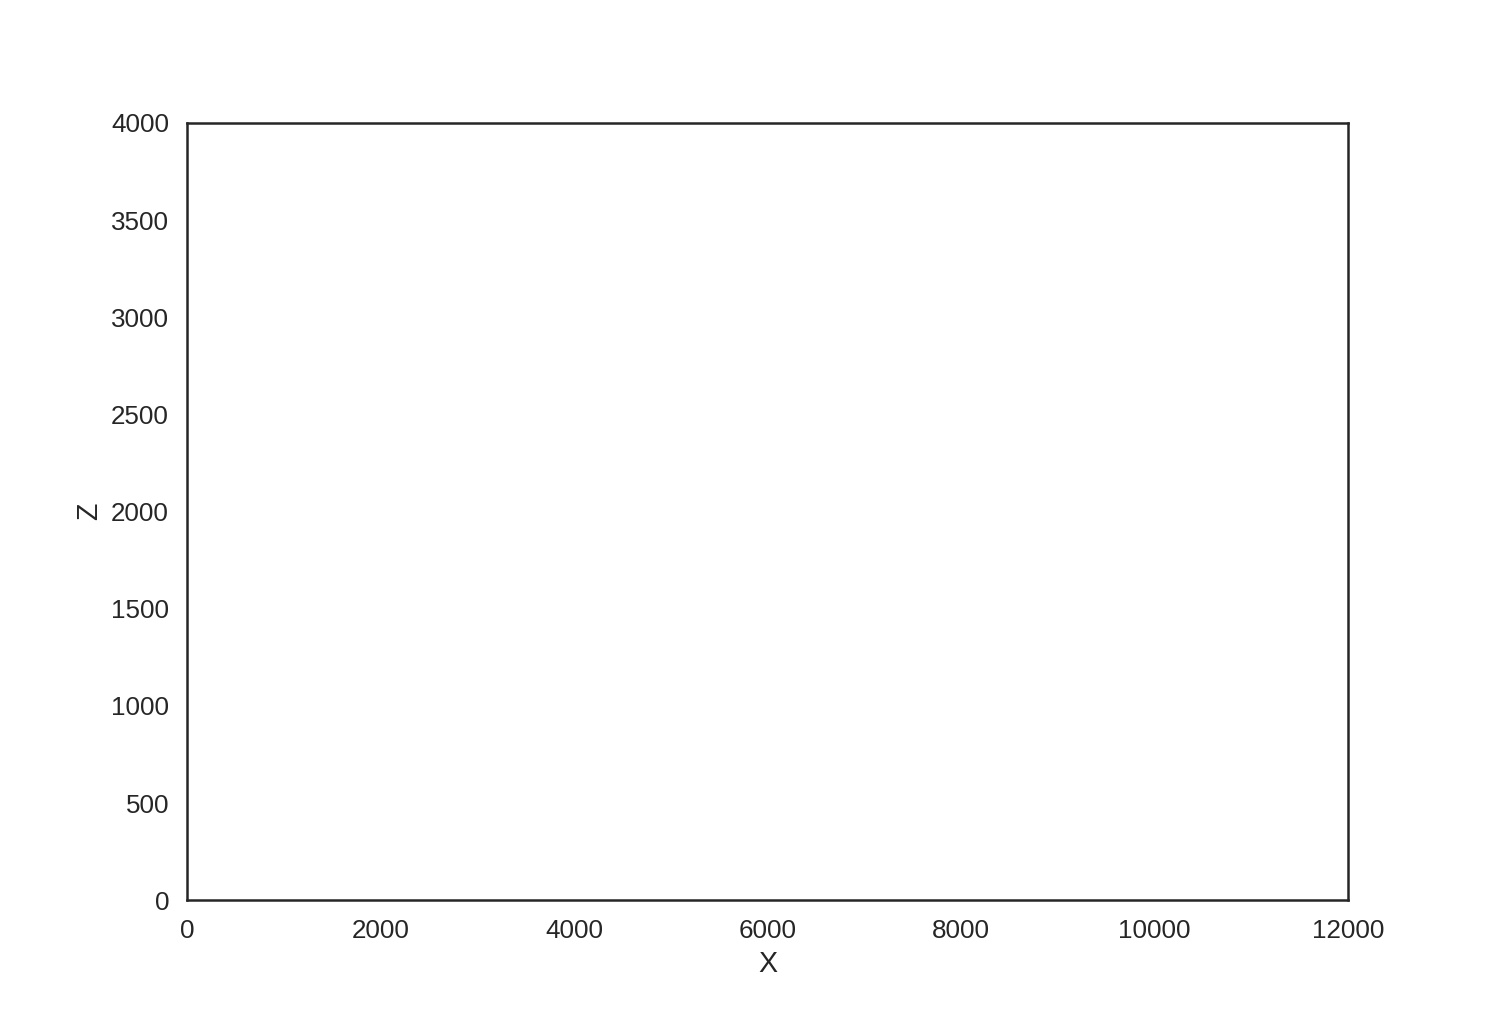

In [73]:
plot_2d(geo_model, )

In [62]:
#p.axjoin.set_xlim(2000, 14000)
#p.axjoin.set_ylim(2000, 14000)

(2000, 14000)

### Plot models:

In [66]:
geo_model.set_active_grid('regular')

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 1.00000000e+01,  5.00000000e+03,  1.00000000e+01],
       [ 1.00000000e+01,  5.00000000e+03,  3.00000000e+01],
       [ 1.00000000e+01,  5.00000000e+03,  5.00000000e+01],
       ...,
       [ 2.10000000e+04,  2.10000000e+04, -8.45432492e+03],
       [ 2.10000000e+04,  2.10000000e+04, -9.28733037e+03],
       [ 2.10000000e+04,  2.10000000e+04, -1.01600000e+04]])

Active grids: ['regular' 'centered']


<IPython.core.display.Javascript object>


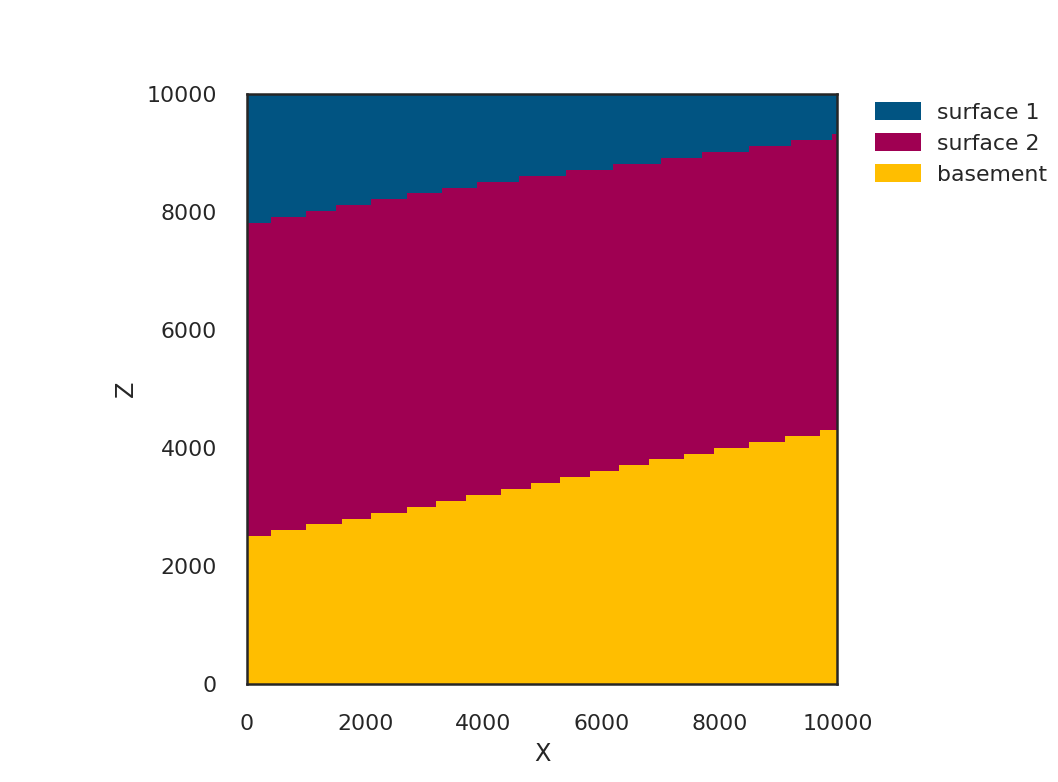

In [71]:

geo_model.set_regular_grid(extent=[0, 10000, 0, 10000, 0, 10000], resolution=[100,2,100])
iteration=300

geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
gp.compute_model(geo_model, output='gravity')
gp.plot.plot_section(geo_model, 0)

In [68]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,color,vertices,edges,id,dz,density
0,surface 1,Default series,1,False,False,True,#015482,"[[0.0, 0.0, 7351.535], [0.0, 5000.0, 7351.535]...","[[2, 1, 0], [3, 1, 2], [4, 3, 2], [5, 3, 4], [...",1,20.0,2.6
1,surface 2,Default series,2,False,False,True,#9f0052,"[[0.0, 0.0, 4369.0776], [0.0, 5000.0, 4369.077...","[[2, 1, 0], [3, 1, 2], [4, 3, 2], [5, 3, 4], [...",2,0.0,2.4
2,basement,Default series,3,True,False,True,#ffbe00,NaN,NaN,3,0.0,3.2


In [69]:
gp.plot.plot_section(geo_model, 0)

### Making gif

In [ ]:
import imageio

In [ ]:
pictures = []

for iteration in range(700):
    p.plot_posterior(['depth_2', 'depth_3'], ['gravity', 'sigma'], 'y', iteration)
    p.axjoin.set_xlim(2000, 14000)
    p.axjoin.set_ylim(2000, 14000)
    p.fig.canvas.draw()
    image = np.frombuffer(p.fig.canvas.tostring_rgb(), dtype='uint8')
    pictures.append(image.reshape(p.fig.canvas.get_width_height()[::-1] + (3,)))

In [ ]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./learning_cheap.gif', pictures[:500:3], fps=24)

### Pyvista

In [ ]:
from gempy.plot import vista
import pyvista as pv
from importlib import reload
reload(vista)
pv.set_plot_theme('document')

gv = vista.Vista(geo_model, plotter_type='basic', notebook=False, real_time=True)
   
a = gv.set_structured_grid()
#gv.set_interactive_data(test_callback=False)

gv.p.open_gif('learning_3D-block.gif')


In [ ]:
gv.p.show(auto_close=False, cpos='xz')


In [ ]:
for iteration in range(0,500,1):
    geo_model.modify_surface_points([0,1,2,3], Z=data.posterior['depths'][0, iteration])#data.get_values('depths')[iteration])
    gp.compute_model(geo_model, output='gravity');
   # print(geo_model.surfaces.df.loc[1,'vertices'][0])
   # gv.call_back_sphere_move_changes(indices = [0,1,2,3])
 #   gv.update_surfaces()
    gv.p.remove_actor(a)
    a = gv.set_structured_grid()    
    gv.p.write_frame()


In [ ]:
gv.p.close()